In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import svm
from sklearn.model_selection import cross_val_score

vector_size = 20

### Labels
walking = 0 pushup = 1 sit-stand = 2 squats = 3

### Walking base

In [136]:
directory = '/home/jovyan/work/backbone/walkingbase'
walking_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        walking_data.append(data_matrix.flatten('F'))

normalized_walking_data = np.vstack(walking_data)
r,c = np.shape(normalized_walking_data)

walking_labels = np.full((r,1), 0)
# normalized_walking_data

### Pushup data

In [137]:
directory = '/home/jovyan/work/backbone/pushupbase'
pushup_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        vec_size = np.shape(data_matrix.flatten('F'));
        if vec_size[0] >= vector_size*3:
            pushup_data.append(data_matrix.flatten('F'))

normalized_pushup_data = np.vstack(pushup_data)
r,c = np.shape(normalized_pushup_data)

pushup_labels = np.full((r,1), 1)

### Sit to stand base

In [138]:
directory = '/home/jovyan/work/backbone/sittostandbase'
sitstand_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        vec_size = np.shape(data_matrix.flatten('F'));
        if vec_size[0] >= vector_size*3:
            sitstand_data.append(data_matrix.flatten('F'))

normalized_sitstand_data = np.vstack(sitstand_data)
r,c = np.shape(normalized_sitstand_data)

sitstand_labels = np.full((r,1), 2)

### Squat base

In [139]:
directory = '/home/jovyan/work/backbone/squatbase'
squat_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        vec_size = np.shape(data_matrix.flatten('F'));
        if vec_size[0] >= vector_size*3:
            squat_data.append(data_matrix.flatten('F'))

normalized_squat_data = np.vstack(squat_data)
r,c = np.shape(normalized_squat_data)

squat_labels = np.full((r,1), 3)

### Aggregate data

In [140]:
# Aggregate all x samples
aggregated_data = []
# aggregated_data.append(normalized_pushup_data)
aggregated_data.append(normalized_walking_data)
aggregated_data.append(normalized_sitstand_data)
aggregated_data.append(normalized_pushup_data)
aggregated_data.append(normalized_squat_data)

# Aggregate all y labels
aggregated_labels = []
aggregated_labels.append(walking_labels)
aggregated_labels.append(sitstand_labels)
aggregated_labels.append(pushup_labels)
aggregated_labels.append(squat_labels)


normalized_X = np.vstack(aggregated_data)
normalized_Y = np.vstack(aggregated_labels)

# Append labels to corresponding row
normalized_X = np.append(normalized_X,normalized_Y, axis=1)

#Shuffle
np.random.shuffle(normalized_X)

# Split back into X and Y
normalized_Y = normalized_X[:,vector_size*3:]
normalized_X = normalized_X[:,:vector_size*3]

### SVM/ SVC

In [141]:
clf = svm.SVC()
clf.fit(normalized_X, np.ravel(normalized_Y))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [142]:
directory = '/home/jovyan/work/backbone/miketestingdata'
test_data = []

for count,filename in enumerate(os.listdir(directory)):
    if filename.endswith(".csv"): 
        data = pd.read_csv(os.path.join(directory,filename))
        data_matrix = data.head(n=vector_size).as_matrix(columns=data.columns[1:])
        vec_size = np.shape(data_matrix.flatten('F'));
        if vec_size[0] >= vector_size*3:
            test_data.append(data_matrix.flatten('F'))

normalized_test_data = np.vstack(test_data)

### Grid Search

In [143]:
from sklearn.model_selection import GridSearchCV

clfgs = svm.SVC(probability=True)
parameters = {'kernel':('linear', 'poly', 'rbf'), 'C':[1, 100]}
clfgs = GridSearchCV(clfgs, parameters)
clfgs.fit(normalized_X, np.ravel(normalized_Y))

sorted(clfgs.cv_results_.keys())
clfgs.cv_results_['mean_test_score']

array([ 0.48924731,  0.35483871,  0.56182796,  0.49462366,  0.73655914,
        0.8172043 ])

### Cross-fold validation and Testing

In [144]:
scores = cross_val_score(clfgs, normalized_X, np.ravel(normalized_Y), cv=10)
np.mean(scores)

0.83084834834834831

### ROC curve for qualitative analysis

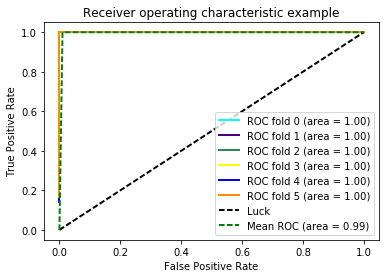

In [145]:
from sklearn.model_selection import StratifiedKFold
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

cv = StratifiedKFold(n_splits=6)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
normalized_Y = np.ravel(normalized_Y)
normalized_X, normalized_Y = normalized_X[normalized_Y != 2], normalized_Y[normalized_Y != 2]
normalized_X, normalized_Y = normalized_X[normalized_Y != 3], normalized_Y[normalized_Y != 3]
clfgsROC = svm.SVC(probability=True)

for (train, test), color in zip(cv.split(normalized_X, normalized_Y), colors):
    clfgsROC.fit(normalized_X[train], normalized_Y[train])
    probas_ = clfgsROC.predict_proba(normalized_X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(normalized_Y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(normalized_X, normalized_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()